# 流程 
加载预训练模型

冻结预训练模型中低层卷积的参数（权重）

用可训练参数的多层替换分类层


在训练集上训练分类层


微调参数，根据需要解冻更多层


Res防止网络层数太深，导致后面学到的特征会越来越少

In [2]:
#加载库
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import os
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import time
from torch.utils.tensorboard import SummaryWriter
import copy
from torch.optim import lr_scheduler
import torch.optim as optim

In [3]:
#OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized. 报错的解决方法
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
#定义一个方法，显示图片
def image_show(inp, title=None):
    inp = inp.numpy().transpose(1,2,0)
    mean = np.array([0.485,0.456,0.486])
    std = np.array([0.229,0.224,0.225])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [5]:
#更改池化层
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self,size=None):
        super().__init__()
        size = (3,3) #池化层的卷积和大小，默认为（1,1）
        self.pool_one = nn.AdaptiveAvgPool2d(size)  
        #https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html?highlight=adaptiveavgpool2d#torch.nn.AdaptiveAvgPool2d
        self.pool_two = nn.AdaptiveAvgPool2d(size)
    
    def forward(self,x):
        return torch.cat((self.pool_one(x),self.pool_two(x)),1) #连接池化层

In [6]:
#定义函数，获取Tensirboard的write
def tb_writer():
    timestr = time.strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter('logdir/'+timestr)
    return writer

In [7]:
#迁移学习，拿到一个成熟的模型进行模型微调
def get_model():
    model_pre = models.resnet50(pretrained=True) 
    #冻结预训练模型中所有的参数
    for param in model_pre.parameters():
        param.requires_grad = False 
    #微调模型：替换Reset最后的两层网络
    model_pre.avgppol = AdaptiveConcatPool2d() #池化层替换
    model_pre.fc = nn.Sequential(
        nn.Flatten(), #所有维度拉平
        nn.BatchNorm1d(2048), #   https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        nn.Dropout(0.5),#丢掉一些神经元
        nn.Linear(2048, 512), #线性层的处理
        nn.ReLU(),#激活层
        nn.BatchNorm1d(512), #正则化处理
        nn.Linear(512,2),
        nn.LogSigmoid(),#损失函数
    )
    return model_pre

In [8]:
#定义训练函数
def train(model,device,train_loader,criterion,optimizer,epoch,writer):
    model.train()
    total_loss = 0.0 #总损失值初始化为0
    #循环读取训练数据集，更新模型参数
    for batch_id, (data,target) in enumerate(train_loader):
        data, target = data.to(device),target.to(device)
        optimizer.zero_grad() #梯度初始化为0
        output = model(data) #训练后的输出
        loss = criterion(output, target) #计算损失
        loss.backward() #反向传播
        optimizer.step() #更新参数
        total_loss += loss.item()
    writer.add_scalar("Train_loss",total_loss/len(train_loader),epoch)
    writer.flush()#刷新
    return total_loss/len(train_loader) #返回平均值

In [9]:
#定义测试函数
def test(model,device,test_loader,criterion,optimizer,epoch,writer):
    #声明在训练模型的时候，不采用batch Normalization 和Dropout
    model.eval()
    #损失值和正确率
    correct = 0.0
    total_loss = 0.0 #总损失值初始化为0
    #循环读取数据
    with torch.no_grad():
        for data,target in test_loader:
            data, target = data.to(device), target.to(device)
        #预测输出
            output = model(data)
        #计算损失
            total_loss += criterion(output,target).item()
        #获取预测结果中每行数据概率最大的下标
            _,pred = torch.max(output,dim=1)
        #累计预测正确的个数
            correct += torch.sum(pred == target.data)

        
    #平均损失
    total_loss /= len(test_loader.dataset)
    #正确率
    accuracy = correct/len(test_loader.dataset)
    #写入日志
    writer.add_scalar('Test Loss',total_loss,epoch)
    writer.add_scalar('Accuracy',accuracy,epoch)
    #刷新
    writer.flush()
    #输出环境
    print("Test Loss: {:.4f},Accuracy: {:.4f}".format(total_loss,accuracy))
    return total_loss, accuracy

In [10]:
def train_epochs(model,device,dataloaders,criterion,optimizer,num_epochs,writer):
    '''
    Rerturns：
        返回一个训练后的最好的模型
    '''
    print("{0:>20}|{1:>20}|{2:>20}|{3:>20}|".format('Epoch0','Training Loss','Test Loss','Accuracy'))
    best_score = np.inf #假设最好的预测值
    start = time.time() #开始时间
    
    #开始循环读取数据进行训练和验证
    for epoch in num_epochs:
        train_loss = train(model,device,dataloaders['train'],criterion,optimizer,epoch,writer)
        test_loss,accuracy = test(model,device,dataloaders['val'],criterion,optimizer,epoch,writer)
        
        if test_loss < best_score:
            best_score = test_loss
            torch.save(model.state_dict(),model_path)#保存模型
            #state_dict变量存放训练过程中需要学的的权重和偏置系统
        print("{0:>20}|{1:>20}|{2:>20}|{3:>20}|".format(epoch,train_loss,test_loss,accuracy))
            
        writer.flush()
        
    #训练完耗费的时间
    time_all = time.time() - start
    #输出时间信息
    print("Training complete in {:.2f}m {:.2f}s").format(time_all // 60, time_all % 60)

In [11]:
#图片转换
date_transforms = {
    'train':
        transforms.Compose([
            transforms.RandomResizedCrop(300),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.486],
                                 [0.229,0.224,0.225]) 
        ]),
 
    'val': 
        transforms.Compose([
            transforms.Resize(300),
            transforms.CenterCrop(256), 
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.486],
                                     [0.229,0.224,0.225])
            ]),
    'test':
        transforms.Compose([
            transforms.Resize(size=300),
            transforms.RandomResizedCrop(size=256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.486],
                                 [0.229,0.224,0.225])
        ]),

}

    

--------------------------------------------------


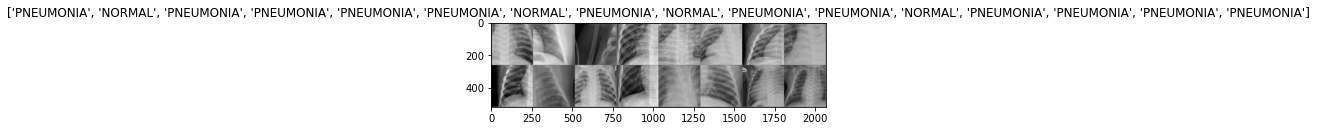

              Epoch0|       Training Loss|           Test Loss|            Accuracy|


C:\Users\user\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test Loss: 0.0004,Accuracy: 0.6875
                   0| 0.18481184536465473|0.00044398210593499243|              0.6875|
Test Loss: 0.0001,Accuracy: 0.7500
                   1|0.009270915424128412|6.53175447951071e-05|                0.75|
Test Loss: 0.0000,Accuracy: 0.6875
                   2|0.002314628650305044|1.9087519831373356e-05|              0.6875|


KeyboardInterrupt: 

In [12]:
#操作数据集
#定义超参数
model_path = 'model.pth'
batch_size = 16
device = torch.device("cpu")

#加载数据集
data_path = r"C:\Users\user\DL\Torch_study\chest_xray"
#加载数据集
image_datasets = {x : datasets.ImageFolder(os.path.join(data_path,x),
                  date_transforms[x]) for x in ['train','val','test'] }
#为数据集创建一个迭代器
dataloaders = {x : DataLoader(image_datasets[x], shuffle=True, 
                              batch_size= batch_size) for x in ['train','val','test']}
#训练集和验证集的大小
data_size =  {x: len(image_datasets[x]) for x in ['train','val','test']}

#获取标签的类别
class_names = image_datasets['train'].classes #一共有两个，肺炎与正常
LABEL = dict((v,k) for k,v in image_datasets['train'].class_to_idx.items())

print("-"*50)

#显示一个batch_size的图片
#读取图片
datas, targets = next(iter(dataloaders['train']))
#将若干张图片拼成一幅图像
out = torchvision.utils.make_grid(datas)
#显示图片
image_show(out,title=[class_names[x] for x in targets])
#将tensor转化为image
inv_normalize = transforms.Normalize(
mean = [-0.485/0.229,-0.456/0.224,-0.406/0.225],
std = [1/0.229,1/0.224,1/0.225]
)

writer = tb_writer()
images, labels = next(iter(dataloaders['train']))#获取一批数据
grid = torchvision.utils.make_grid([inv_normalize(image) for image in images[:32]])#获取32张图片
writer.add_image('X-Ray grid', grid,0) #添加到TensorBoard
writer.flush() #将数据读取到储存器

model = get_model().to(device)#获取模型
criterion = nn.NLLLoss()#损失函数
optimizer = optim.Adam(model.parameters())
train_epochs(model,device,dataloaders,criterion,optimizer,range(0,10),writer)
writer.close()